# Imports for Python libraries

In [35]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np
import torch
import torchvision
import matplotlib.pyplot as plt
from time import time
from torchvision import datasets, transforms
from torch import nn
from torch import optim

# Set up the mini-batch size

In [36]:
#@title Batch Size
mini_batch_size = 60000 # 64 for the second example

# Download the dataset, pre-process, and divide into mini-batches

In [37]:
### Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,)),])

### Download and load the training data
trainset = datasets.MNIST('MNIST_data/', download=True, train=True, transform=transform)
valset = datasets.MNIST('MNIST_data/', download=True, train=False, transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=mini_batch_size, shuffle=True)
valloader = torch.utils.data.DataLoader(valset, batch_size=mini_batch_size, shuffle=True)
dataiter = iter(trainloader)
images, labels = next(dataiter)
print(type(images))
print(images.shape)
print(labels.shape)

<class 'torch.Tensor'>
torch.Size([64, 1, 28, 28])
torch.Size([64])


# Explore the processed data

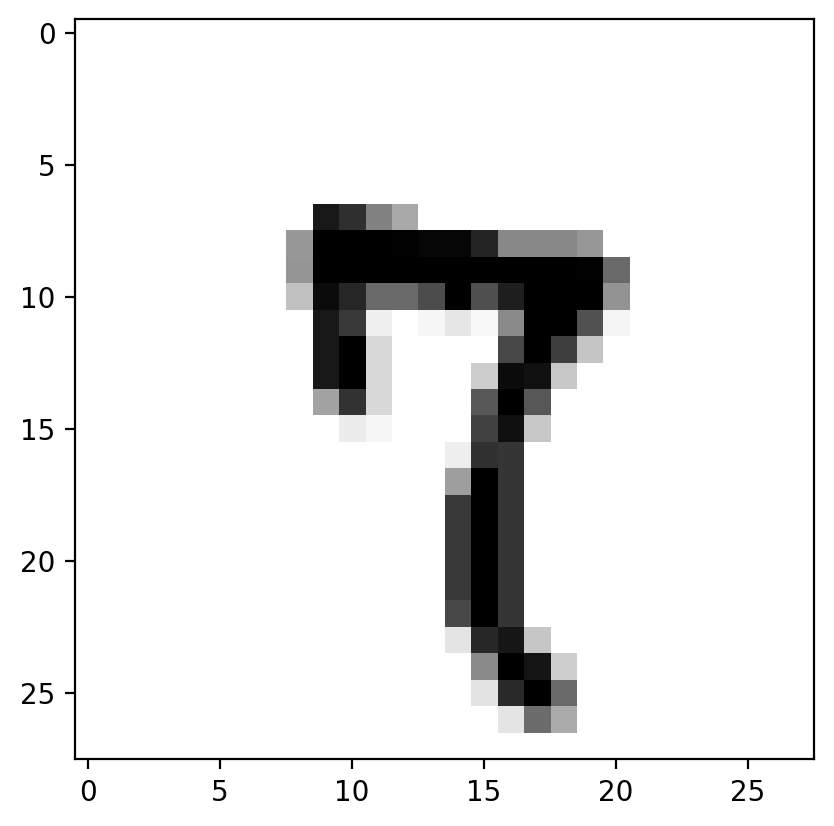

In [14]:
plt.imshow(images[0].numpy().squeeze(), cmap='gray_r'); # Change the index of images[] to get different numbers

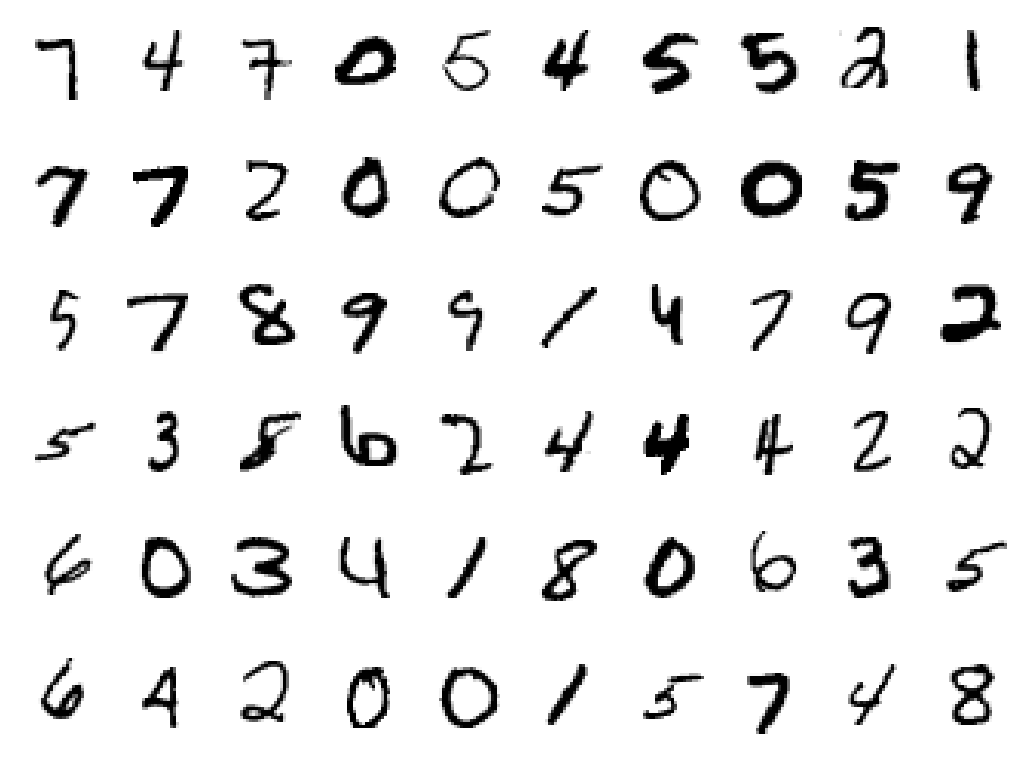

In [15]:
figure = plt.figure()
num_of_images = 60
for index in range(1, num_of_images + 1):
    plt.subplot(6, 10, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

# Set up the neural network

In [38]:
# Please change the runtime to GPU if you'd like to have some speed-up on Colab
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Layer details for the neural network
input_size = 784
hidden_sizes = [128, 64]
output_size = 10

### Build a feed-forward network
model = nn.Sequential(
    nn.Linear(input_size, hidden_sizes[0]), # Fully Connected Layer
    nn.ReLU(), # Activation
    nn.Linear(hidden_sizes[0], hidden_sizes[1]), # Fully Connected Layer
    nn.ReLU(), # Activation
    nn.Linear(hidden_sizes[1], output_size), # Fully Connected Layer
    nn.LogSoftmax(dim=1) # (Log) Softmax Layer: Output a probability distribution and apply log
)
print(model)
model.to(device)

Sequential(
  (0): Linear(in_features=784, out_features=128, bias=True)
  (1): ReLU()
  (2): Linear(in_features=128, out_features=64, bias=True)
  (3): ReLU()
  (4): Linear(in_features=64, out_features=10, bias=True)
  (5): LogSoftmax(dim=1)
)


Sequential(
  (0): Linear(in_features=784, out_features=128, bias=True)
  (1): ReLU()
  (2): Linear(in_features=128, out_features=64, bias=True)
  (3): ReLU()
  (4): Linear(in_features=64, out_features=10, bias=True)
  (5): LogSoftmax(dim=1)
)

# Set up the optimization model

In [39]:
#@title Optimizer
lr = 0.003 #@param {type: "number"}
optimizer = optim.SGD(model.parameters(), lr=lr) # Feel free to try out other optimizers as you see fit!

# Set up the loss function to optimize over

In [40]:
time0 = time()
epochs = 15
criterion = nn.NLLLoss() # Negative log likelihood loss function is used
images, labels = next(iter(trainloader))
images = images.view(images.shape[0], -1).to(device)

logps = model(images) # Model spits out the log probability of image belonging to different classes
loss = criterion(logps, labels.to(device))

# Train the neural network

In [29]:
for e in range(epochs):
    running_loss = 0
    for images, labels in trainloader:
        # Flatten MNIST images into a 784 long vector
        images = images.view(images.shape[0], -1).to(device)
        labels = labels.to(device)

        # Training pass
        optimizer.zero_grad()

        output = model(images).to(device)
        loss = criterion(output, labels)

        # backpropagation: calculate the gradient of the loss function w.r.t model parameters
        loss.backward()

        # And optimizes its weights here
        optimizer.step()

        running_loss += loss.item()
    else:
        print("Epoch {} - Training loss: {}".format(e, running_loss/len(trainloader)))
print("\nTraining Time (in minutes) =", (time()-time0)/60)

Epoch 0 - Training loss: 2.3176991939544678
Epoch 1 - Training loss: 2.3168911933898926
Epoch 2 - Training loss: 2.316086530685425
Epoch 3 - Training loss: 2.3152847290039062
Epoch 4 - Training loss: 2.314486026763916
Epoch 5 - Training loss: 2.313690423965454
Epoch 6 - Training loss: 2.312898635864258
Epoch 7 - Training loss: 2.312110185623169
Epoch 8 - Training loss: 2.3113248348236084
Epoch 9 - Training loss: 2.310541868209839
Epoch 10 - Training loss: 2.309762477874756
Epoch 11 - Training loss: 2.3089864253997803
Epoch 12 - Training loss: 2.308213949203491
Epoch 13 - Training loss: 2.3074474334716797
Epoch 14 - Training loss: 2.306684732437134

Training Time (in minutes) = 4.1997338453928625


# Evaluate the trained neural network

In [30]:
correct_count, all_count = 0, 0
for images, labels in valloader:
    for i in range(len(labels)):
        img = images[i].view(1, 784).to(device)
        labels = labels.to(device)
        # Forward pass only during evaluation
        with torch.no_grad():
            logps = model(img)

        # Output of the network are log-probabilities, need to take exponential for probabilities
        ps = torch.exp(logps)
        probab = list(ps.cpu().numpy()[0])
        pred_label = probab.index(max(probab))
        true_label = labels.cpu().numpy()[i]
        if true_label == pred_label:
            correct_count += 1
        all_count += 1

print("Number Of Images Tested =", all_count)
print("\nModel Accuracy =", (correct_count/all_count))

Number Of Images Tested = 10000

Model Accuracy = 0.1217


# Predict using the trained neural network

In [21]:
def view_classify(img, ps):
    """ Function for viewing an image and it's predicted classes."""
    ps = ps.data.numpy().squeeze()

    fig, (ax1, ax2) = plt.subplots(figsize=(6,9), ncols=2)
    ax1.imshow(img.resize_(1, 28, 28).numpy().squeeze())
    ax1.axis('off')
    ax2.barh(np.arange(10), ps)
    ax2.set_aspect(0.1)
    ax2.set_yticks(np.arange(10))
    ax2.set_yticklabels(np.arange(10))
    ax2.set_title('Class Probability')
    ax2.set_xlim(0, 1.1)
    plt.tight_layout()

Predicted Digit = 9


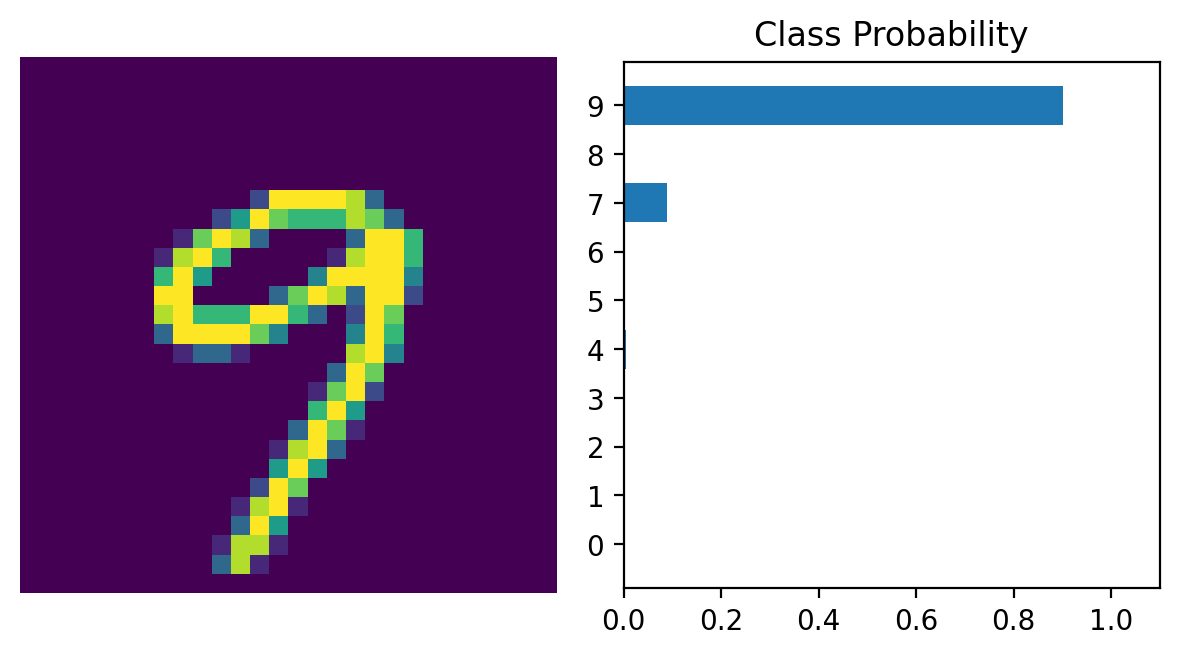

In [22]:
images, labels = next(iter(valloader))

img = images[0].view(1, 784).to(device)
# Turn off gradients
with torch.no_grad():
    logps = model(img)

# Output of the network are log-probabilities, need to take exponential for probabilities
ps = torch.exp(logps)
probab = list(ps.cpu().numpy()[0])
print("Predicted Digit =", probab.index(max(probab)))
view_classify(img.cpu().view(1, 28, 28), ps.cpu())

In [41]:
# adam code

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from time import time

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define model
model = nn.Sequential(
    nn.Linear(784, 128),
    nn.ReLU(),
    nn.Linear(128, 64),
    nn.ReLU(),
    nn.Linear(64, 10),
    nn.LogSoftmax(dim=1)
).to(device)

# Define loss and ADAM optimizer
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters())

# Training loop
epochs = 15
time0 = time()
for e in range(epochs):
    running_loss = 0
    for images, labels in trainloader:
        images = images.view(images.shape[0], -1).to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        output = model(images)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    else:
        print(f"Epoch {e+1} - Training loss: {running_loss/len(trainloader)}")
print("Training Time (in minutes) =", (time()-time0)/60)

Epoch 1 - Training loss: 0.394544350455946
Epoch 2 - Training loss: 0.18847043788247209
Epoch 3 - Training loss: 0.13834775539377192
Epoch 4 - Training loss: 0.11325888654618248
Epoch 5 - Training loss: 0.09436626482540483
Epoch 6 - Training loss: 0.08334825627867189
Epoch 7 - Training loss: 0.07088808878523502
Epoch 8 - Training loss: 0.06413840817169411
Epoch 9 - Training loss: 0.05725385713838299
Epoch 10 - Training loss: 0.0534968657703546
Epoch 11 - Training loss: 0.05051764201182725
Epoch 12 - Training loss: 0.04773022012133747
Epoch 13 - Training loss: 0.04247306544053952
Epoch 14 - Training loss: 0.04068588262238887
Epoch 15 - Training loss: 0.037400189261651534
Training Time (in minutes) = 4.694460042317709


In [42]:
correct_count, all_count = 0, 0
for images, labels in valloader:
    for i in range(len(labels)):
        img = images[i].view(1, 784).to(device)
        labels = labels.to(device)
        with torch.no_grad():
            logps = model(img)
        ps = torch.exp(logps)
        pred_label = ps.argmax(dim=1).item()
        true_label = labels[i].item()
        if pred_label == true_label:
            correct_count += 1
        all_count += 1

print("Number Of Images Tested =", all_count)
print("Model Accuracy =", correct_count / all_count)

Number Of Images Tested = 10000
Model Accuracy = 0.9742
